## Set-up

Necessary imports and helper functions

In [ ]:
import json
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from PIL import Image
from typing import Dict, Optional, Sequence, List

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, get_model_name_from_path
from mask_vis_tools import save_mask, save_box, save_points

torch.cuda.empty_cache()

Define Task Modes

In [2]:
task_modes = {
    "brief_cap_en": "<image>\nProvide a concise caption for this subject.",
    "brief_cap_ch": "<image>\n对该目标对象提供一个概括的描述",
    "detail_cap_en": "<image>\nProvide a comprehensive and detailed description for this subject.",
    "detail_cap_ch": "<image>\n对该目标对象提供一个全面且详细的描述",
    "recognize_en": "<image>\nClassify this subject and provide its label.",
    "recognize_ch": "<image>\n对该目标对象进行分类并提供标签",
    "explain_en": "<image>\nClassify this subject and provide the label and its definition.",
    "explain_ch": "<image>\n对该目标对象进行分类并提供标签和名词功能解释"
}

Load PAM Model

In [ ]:
device = "cuda:0"
model_path = "path/to/PAM_ckpt"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path),
    multimodal=True,
    torch_dtype="bfloat16", # bfloat16, float16
    device_map="cuda"
)
model.to(device)

temperature = 0.1
top_p = None
num_beams = 1

Example Image

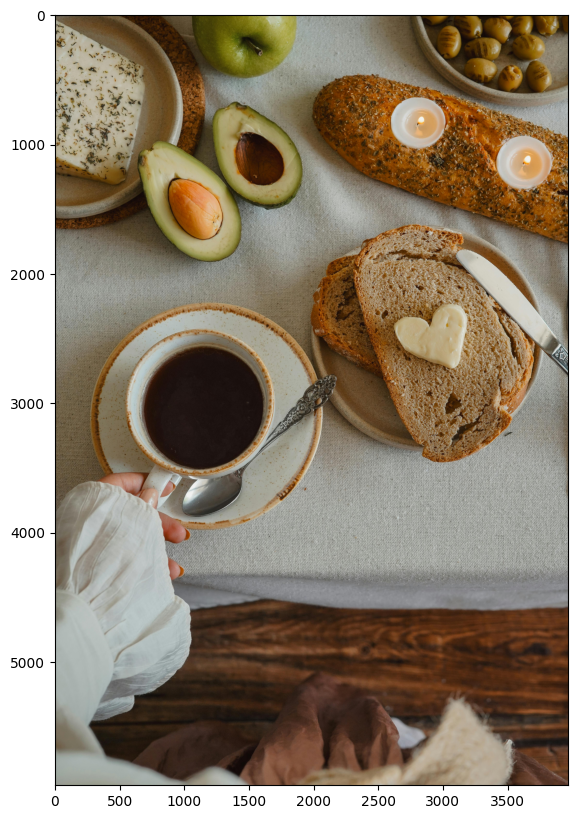

In [4]:
image = 'images/exp_1.jpg'
image_np = Image.open(image)
image_np = np.array(image_np.convert("RGB"))
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('on')
plt.show()

Specifying a specific object with a box. The model takes a box as input, provided in xyxy format.

In [13]:
task_prompt = task_modes["detail_cap_en"]

conv = conv_templates["qwen_2"].copy()
conv.append_message(conv.roles[0], task_prompt)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(device)

bbox_xywh = [847, 2691, 1341, 1214]
x1, y1 = int(bbox_xywh[0]), int(bbox_xywh[1])
x2, y2 = int(bbox_xywh[0] + bbox_xywh[2]), int(bbox_xywh[1] + bbox_xywh[3])
bbox_xyxy = [x1, y1, x2, y2]
visual_prompts = bbox_xyxy
vp_labels = None

Generate semantic outputs and mask outputs.

In [ ]:
with torch.inference_mode():
    output_ids, all_masks_logits, all_scores = model.generate(
        input_ids,
        images=[[image]],
        visual_prompts=[visual_prompts],
        vp_labels=[vp_labels],
        types=['image'],
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=512,
        use_cache=True)

outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

print("Prediction: ", outputs)

for _, (img, vps, labels, masks) in enumerate(zip([image], [visual_prompts], [vp_labels], all_masks_logits)):
    img = Image.open(img).convert('RGB')
    img = np.array(img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.set_title(f"mask score: {all_scores[0][0]}")
    for i, mask in enumerate((masks[0] > 0.0).cpu().numpy()):
        save_mask(mask, ax, borders=True)
    save_box(vps, ax)
    plt.axis('on')
    plt.show()

Specifying a specific object with points.

In [15]:
task_prompt = task_modes["detail_cap_ch"]

conv = conv_templates["qwen_2"].copy()
conv.append_message(conv.roles[0], task_prompt)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(device)

visual_prompts = [[1175, 3669], [1705, 3198], [1434, 3404]]
vp_labels = [1, 1, 0] # 1 means pos, 0 means neg

[1175, 3669] 1
[1705, 3198] 1
[1434, 3404] 0


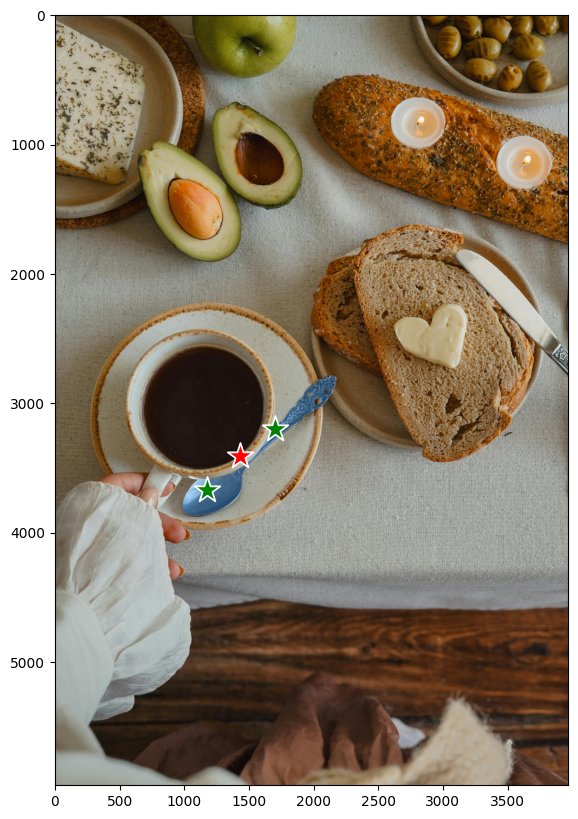

Prediction:  一把金属勺子，表面光滑反光。勺柄装饰着精美的涡卷花纹，末端逐渐收窄成尖头。勺身呈椭圆形，边缘略带弧度。
mask_score:  [20.625]


In [16]:
with torch.inference_mode():
    output_ids, all_masks_logits, all_scores = model.generate(
        input_ids,
        images=[[image]],
        visual_prompts=[visual_prompts],
        vp_labels=[vp_labels],
        types=['image'],
        do_sample=True if temperature > 0 else False,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=512,
        use_cache=True)

outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
print("Prediction: ", outputs)

for _, (img, vps, labels, masks) in enumerate(zip([image], [visual_prompts], [vp_labels], all_masks_logits)):
    img = Image.open(img).convert('RGB')
    img = np.array(img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.set_title(f"mask score: {all_scores[0][0]}")
    for i, mask in enumerate((masks[0] > 0.0).cpu().numpy()):
        save_mask(mask, ax, borders=True)
    for point, label in zip(vps, labels):
        print(point, label)
        save_points(point, label, ax)
    plt.axis('on')
    plt.show()